# IMPORTS

In [1]:
import sys
sys.path.append('/Users/daniel/OAN/SID/')
import pandas

from dotenv import load_dotenv
 
load_dotenv(dotenv_path='/Users/daniel/OAN/SID/.env')

True

In [2]:
import sid_modules.helperFunctions as hf

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import re
import time

In [4]:
from scipy import ndimage
from tqdm import tqdm

In [5]:
df_images = hf.BigQueryHelper().loadImages()

Downloading: 100%|██████████| 5/5 [00:00<00:00, 28.46rows/s]


In [6]:
df_images

img_name          name  input_lat  input_lon  input_size  \
0        Monnon_5_19_500.png        Monnon   9.842513   3.178864         500   
1   Sansi Gando_5_19_500.png   Sansi Gando   9.947919   3.418565         500   
2  Besen Gourou_5_19_500.png  Besen Gourou   9.905893   3.350370         500   
3      Barkedje_5_19_500.png      Barkedje  10.025566   3.287887         500   
4        Boudal_5_19_500.png        Boudal   9.866730   3.172789         500   

   grid_size  zoom  lat_size  lon_size      lat_0     lon_0  m_per_px_lat  \
0          5    19      2285      2500   9.845532  3.175517      0.294187   
1          5    19      2285      2500   9.950937  3.415034      0.294093   
2          5    19      2285      2500   9.908911  3.346920      0.294131   
3          5    19      2285      2500  10.028584  3.284179      0.294023   
4          5    19      2285      2500   9.869749  3.169404      0.294166   

   m_per_px_lon  deg_per_m_lat  deg_per_m_lon  deg_per_px_lat  deg_per_px_lon  
0      0.298123       0.000008       0.000009        0.000002        0.000003  
1      0.298051       0.000008       0.000009        0.000002        0.000003  
2      0.298072       0.000008       0.000009        0.000002        0.000003  
3      0.298091       0.000008       0.000010        0.000002        0.000003  
4      0.298124       0.000008       0.000009        0.000002        0.000003

In [7]:
imreads = dict()
for vill in df_images['name'].unique():
    imreads[vill] = cv2.imread('/Users/daniel/OAN/SID/poc/'+vill+'_5_19_500.png')

In [8]:
df = pd.read_gbq('SELECT * from output_data.poc_buildings_from_labeled')

In [9]:
df['houses'] = df['houses'].apply(eval)

## GET HOUSE

In [10]:
vill = df_images.iloc[1]['name']
vill

'Sansi Gando'

In [11]:
image = cv2.imread('/Users/daniel/OAN/SID/poc/'+vill+'_5_19_500.png')

In [12]:
df_vill = df[df['village']==vill].reset_index(drop=True)

In [13]:
house = df_vill['houses'].iloc[3]
house

[[1289, 1303], [1286, 1317], [1302, 1319], [1304, 1306]]

In [14]:
pts = np.array(house)

## (1) Crop the bounding rect
rect = cv2.boundingRect(pts)
x,y,w,h = rect
croped = image[y:y+h, x:x+w].copy()

## (2) make mask
pts = pts - pts.min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)

## (4) add the white background
bg = np.ones_like(croped, np.uint8)*255
cv2.bitwise_not(bg,bg, mask=mask)
dst2 = bg+ dst

In [15]:
house_pixels = dst2.reshape(dst2.shape[0]*dst2.shape[1],dst2.shape[2])

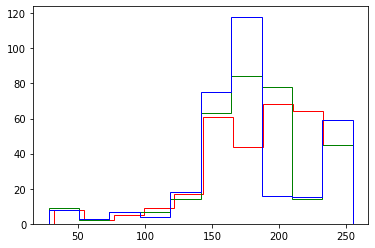

In [16]:
color = ['red','green','blue']
for i in range(3):
    plt.hist([pix[i] for pix in house_pixels], color=color[i],histtype='step')
plt.show()

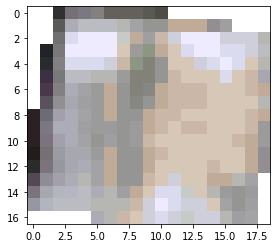

In [17]:
plt.imshow(dst2)

In [18]:
def get_house_pixels(x):
    vill = x['village']
    house = x['houses']
    
    image = imreads[vill]
    pts = np.array(house)

    ## (1) Crop the bounding rect
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = image[y:y+h, x:x+w].copy()

    ## (2) make mask
    pts = pts - pts.min(axis=0)

    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask)

    ## (4) add the white background
    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg+ dst

    house_pixels = dst2.reshape(dst2.shape[0]*dst2.shape[1],dst2.shape[2])
    house_pixels_nw = [pix for pix in house_pixels if (pix != [255,255,255]).all()]
    
    return house_pixels_nw

In [19]:
df['house_pixels_nw'] = df.apply(lambda x: get_house_pixels(x), axis=1)

In [20]:
df_metal = df[df['type']=='metal']

In [21]:
df_metal.shape

(284, 15)

In [22]:
metal_dict = df_metal.T.to_dict()
all_pixels = []
l_village = []
l_house_n = []
for i in metal_dict:
    row = metal_dict[i]
    pixels = row['house_pixels_nw']
    all_pixels= all_pixels+pixels
    l_village = l_village+[row['village'] for p in pixels]
    l_house_n = l_house_n+[i for p in pixels]

In [23]:
df_pixels = pd.DataFrame({'all_pix':all_pixels,
              'village':l_village,
              'house':l_house_n})

In [24]:
df_pixels.shape

(289485, 3)

In [25]:
df_pixels['red'] = df_pixels['all_pix'].apply(lambda x: x[0])
df_pixels['green'] = df_pixels['all_pix'].apply(lambda x: x[1])
df_pixels['blue'] = df_pixels['all_pix'].apply(lambda x: x[2])

In [26]:
conn = sqlite3.connect("pixels.sqlite")
conn.execute('DROP TABLE poc_pixels')
conn.commit()
df_pixels.to_sql('poc_pixels',conn)

In [32]:
most_pix = df_pixels['all_pix'].apply(tuple).value_counts().reset_index()

In [33]:
most_pix.columns = ['pixel','count']

In [35]:
most_pix.shape

(2712, 2)

In [38]:
most_pix.to_gbq('output_data.house_pixels_counts','sidhouses')

1it [00:02,  2.05s/it]


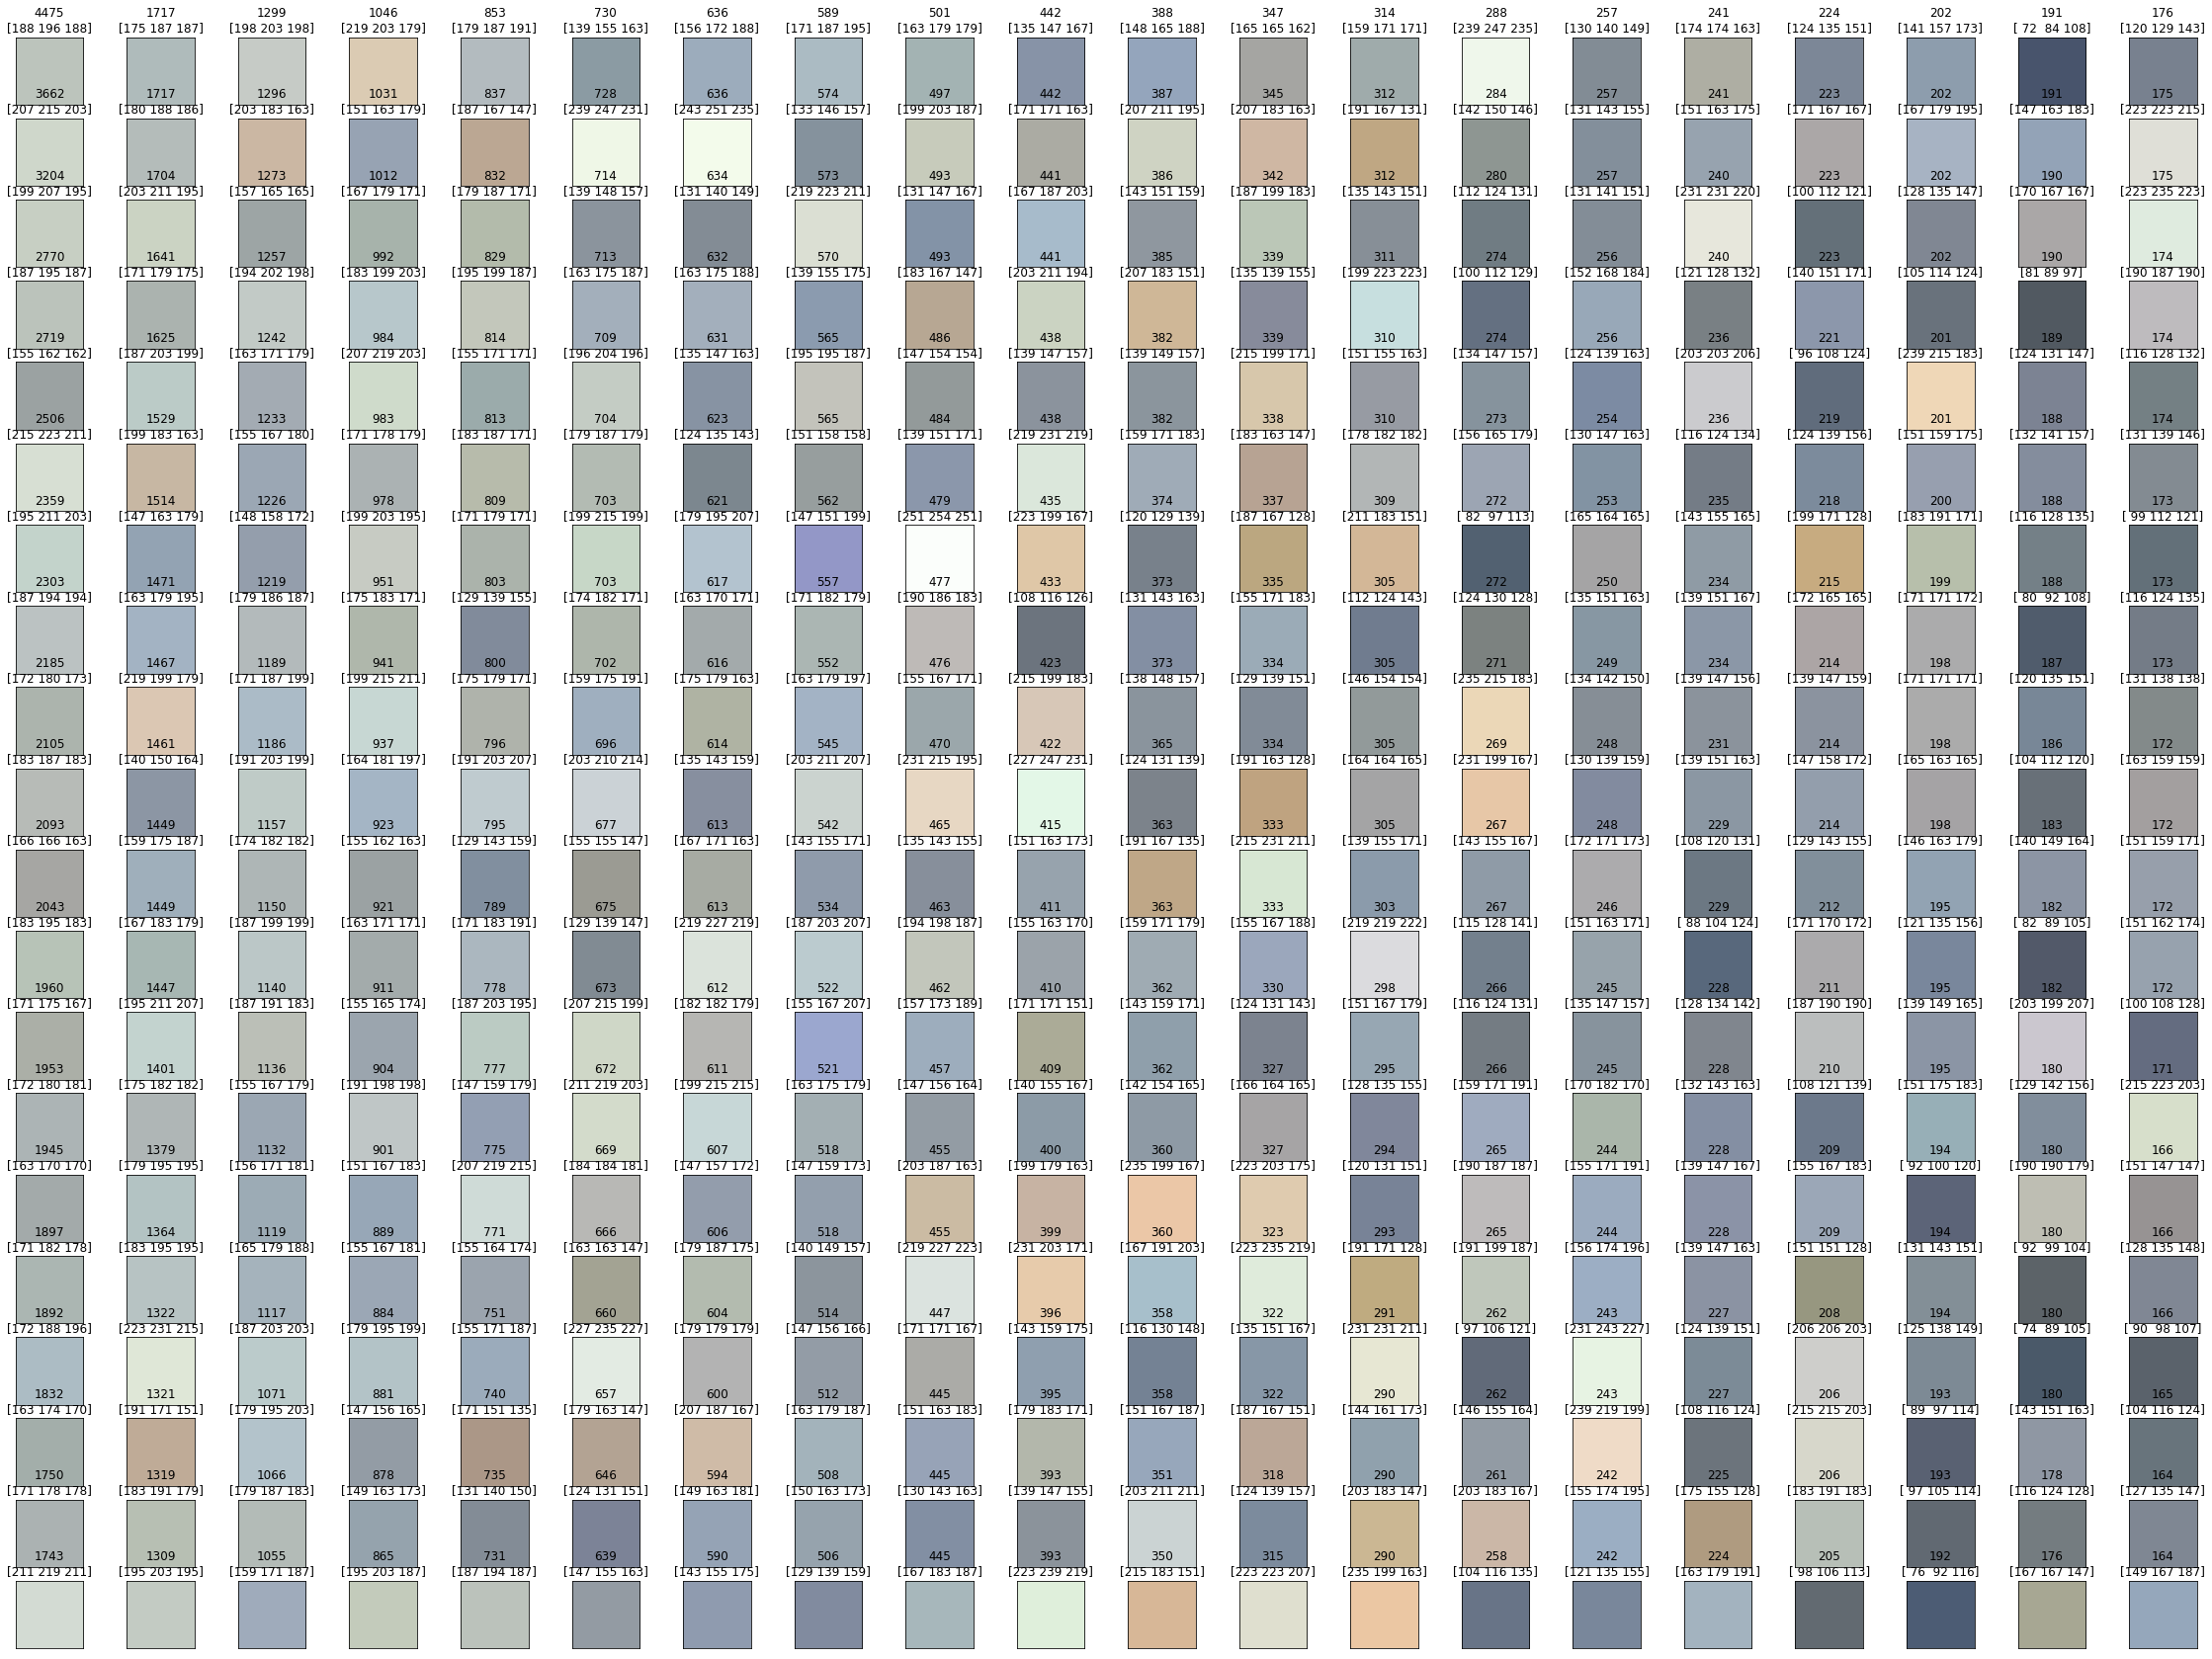

In [32]:
f, ax = plt.subplots(20,20,figsize=(40,30))
mmdict = most_pix.iloc[0:400].T.to_dict()
for rr,k in enumerate(mmdict):
    row = mmdict[k]
    piixel = eval(re.sub(r'(\d)\s+(\d)', r'\1,\2',row['pixel']))
    pix_im = np.ones(shape=(4,4,3))
    im_pix = np.where(pix_im==[1,1,1],piixel,[0,0,0])
    axx = ax[rr%20,int(rr/20)]
    axx.imshow(im_pix)
    axx.set_title(str(row['count'])+'\n'+row['pixel'])
    axx.get_xaxis().set_visible(False)
    axx.get_yaxis().set_visible(False)
plt.show()

In [33]:
best_pix_100 = [eval(re.sub(r'(\d)\s+(\d)', r'\1,\2',pp)) for pp in most_pix.iloc[0:100]['pixel'].to_list()]

In [34]:
best_pix = [pp for pp in best_pix_100 if (pp[0]-pp[2]) < 30]

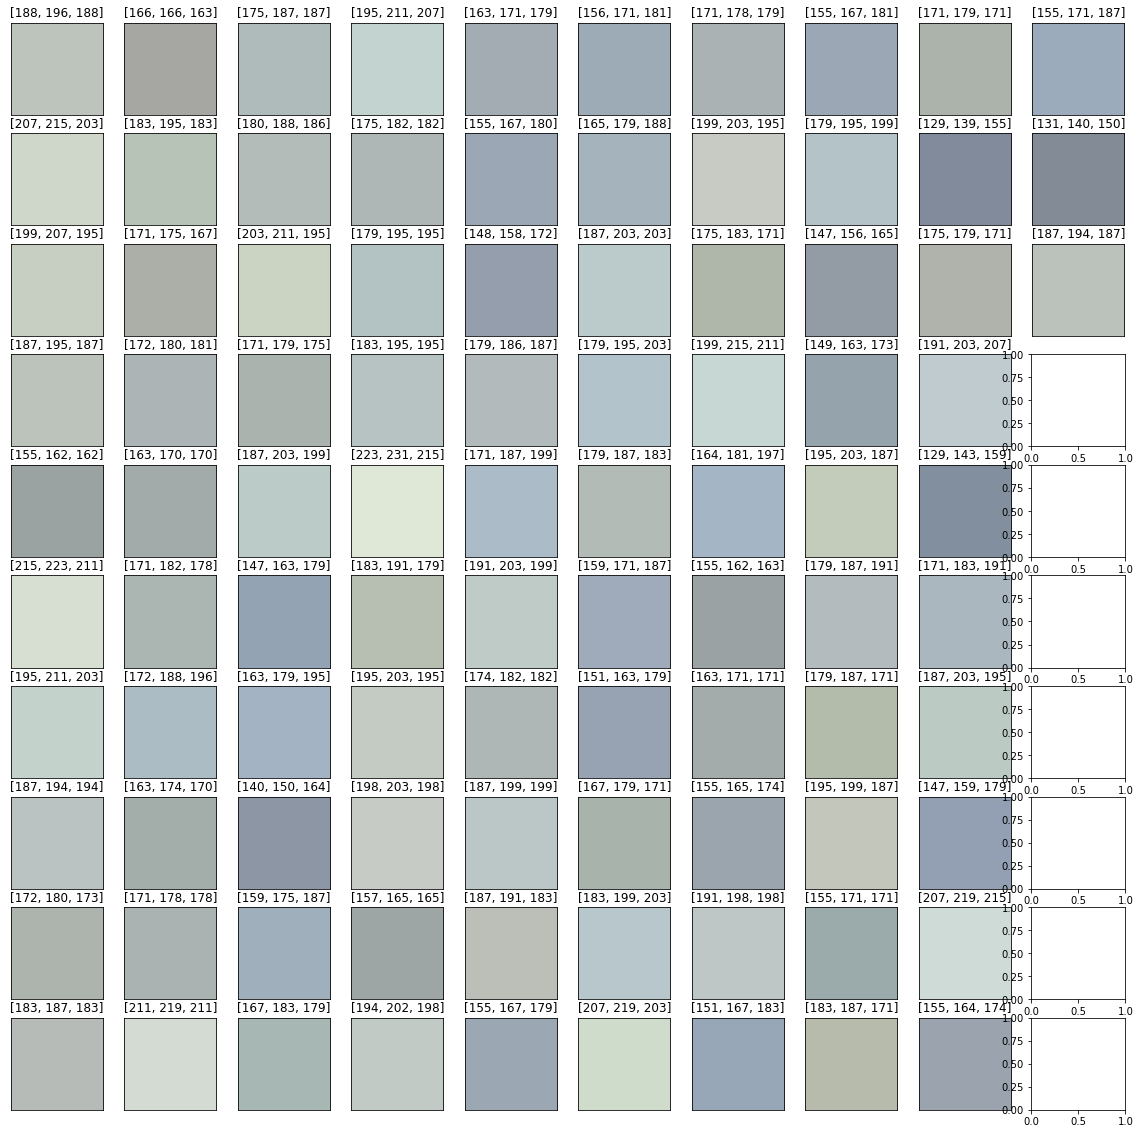

In [35]:
n=10
f, ax = plt.subplots(n,n,figsize=(20,20))
mmdict = best_pix
for rr,k in enumerate(mmdict):
    piixel = k
    pix_im = np.ones(shape=(4,4,3))
    im_pix = np.where(pix_im==[1,1,1],piixel,[0,0,0])
    axx = ax[rr%n,int(rr/n)]
    axx.imshow(im_pix)
    axx.set_title(str(k))
    axx.get_xaxis().set_visible(False)
    axx.get_yaxis().set_visible(False)
plt.show()

In [36]:
best_pix_300 = [eval(re.sub(r'(\d)\s+(\d)', r'\1,\2',pp)) for pp in most_pix.iloc[0:300]['pixel'].to_list()]

In [39]:
best_pix = [pp for pp in best_pix_300 if (pp[0]-pp[2]) < 30]

In [40]:
len(best_pix)

264

In [41]:
im_monnon = imreads['Monnon'].copy()

In [42]:
im_monnon_mask = [imreads['Monnon'].copy() for a in best_pix]

In [46]:
tbest_pix = tqdm(best_pix)
start_time = time.time()
for b,bp in enumerate(tbest_pix):
    im_monnon_copy = im_monnon.copy()
    im_monnon_copy[np.all(im_monnon_copy == bp, axis=-1)] = [255,0,0]
    im_monnon_copy[np.logical_not(np.all(im_monnon_copy == [255,0,0], axis=-1))] = [0,0,0]
    im_monnon_mask[b] = im_monnon_copy
end_time = time.time()
print('took: {}'.format(end_time-start_time))

100%|██████████| 264/264 [02:30<00:00,  1.75it/s]

took: 150.69951272010803


In [47]:
im_monnon_mask_sum = np.zeros(shape = im_monnon.shape)
for i,elem in enumerate(im_monnon_mask):
    im_monnon_mask_sum = np.add(im_monnon_mask_sum,elem)

In [48]:
im_monnon_mask_sum=np.array(im_monnon_mask_sum,dtype='int32')

In [49]:
#image_ana=im_monnon_mask_sum

In [50]:
#dff_ana = pd.DataFrame(image_ana.reshape(image_ana.shape[0]*image_ana.shape[1],
#                           image_ana.shape[2]))

In [51]:
#dff_ana[0].value_counts()

In [52]:
#dff_ana[1].value_counts()

In [53]:
#dff_ana[2].value_counts()

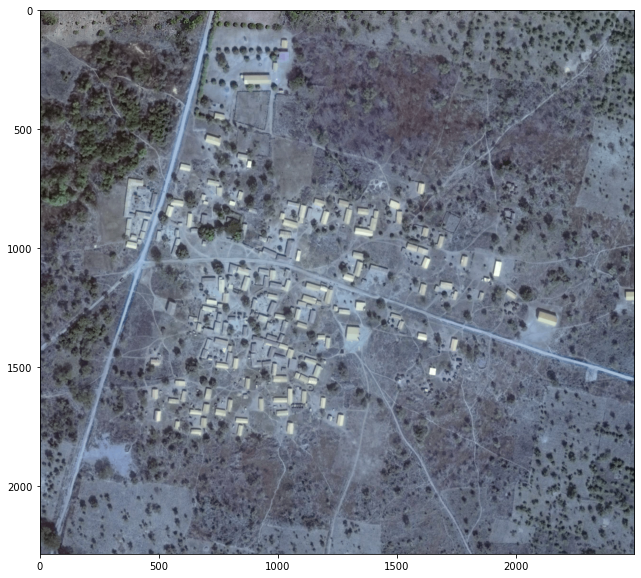

In [54]:
plt.figure(figsize=(20,10))
plt.imshow(im_monnon)

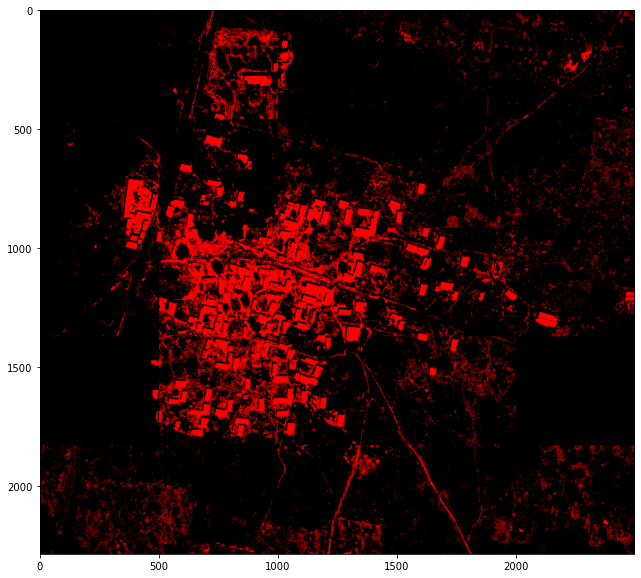

In [55]:
plt.figure(figsize=(20,10))
plt.imshow(im_monnon_mask_sum)

In [56]:
im_monnon_wh = im_monnon.copy()

In [57]:
im_monnon_wh[np.all(im_monnon_mask_sum == [255,0,0], axis=-1)] = [255,0,0]

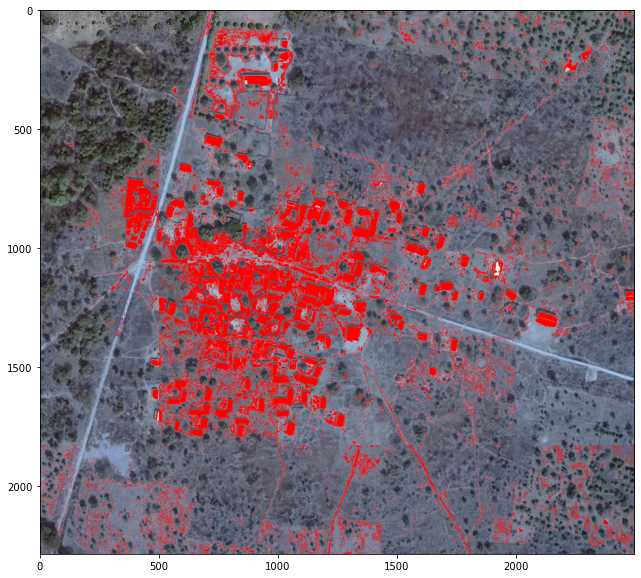

In [58]:
plt.figure(figsize=(20,10))
plt.imshow(im_monnon_wh)

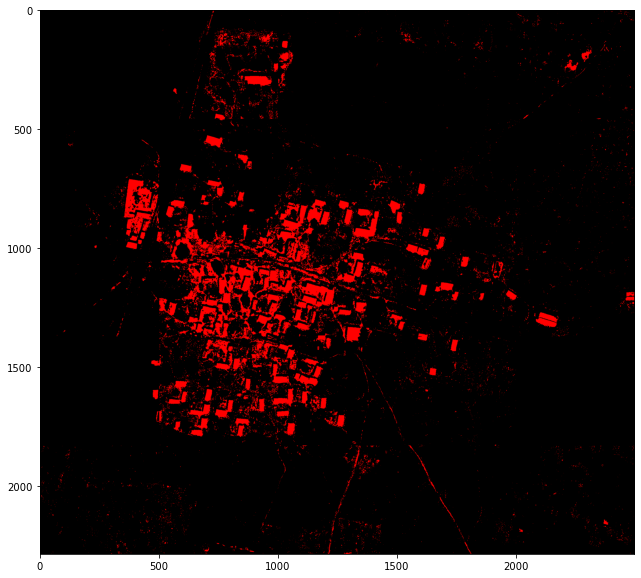

In [59]:
median = cv2.blur(im_monnon_wh,ksize=(2,2))
median[np.all(np.logical_not(median==[255,0,0]),axis=-1)]=[0,0,0]
plt.figure(figsize=(20,10))
plt.imshow(median)

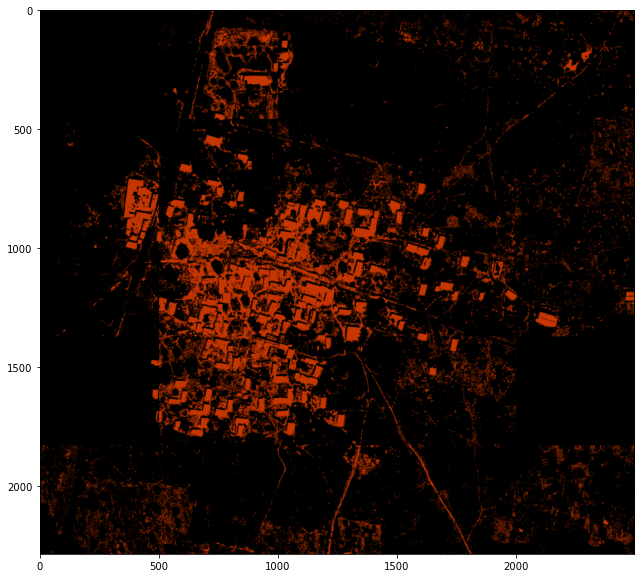

In [60]:
plt.figure(figsize=(20,10))
g_fil = ndimage.gaussian_filter(im_monnon_mask_sum,0.7)
plt.imshow(g_fil)

In [61]:
g_fil_r = g_fil[:,:,0]

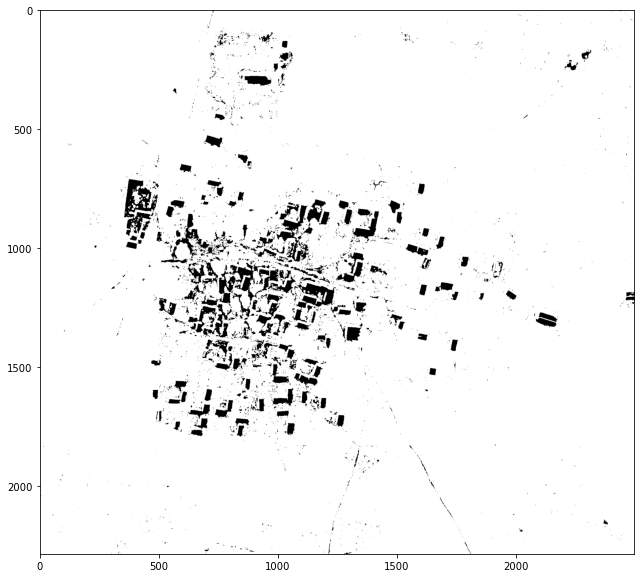

In [62]:
plt.figure(figsize=(20,10))
plt.imshow(np.where(190 < g_fil_r,0,255),'gray')

## OPTIMISED ALGORITHM

In [63]:
result = np.where(195 < g_fil[:,:,0],1,0).astype(np.uint8)
#result = np.where(median[:,:,0] == 255,1,0).astype(np.uint8)

In [64]:
result.shape

(2285, 2500)

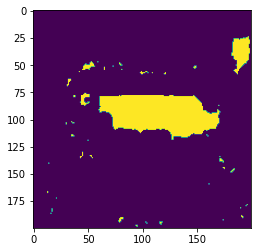

In [65]:
plt.imshow(result[200:400,800:1000])

In [67]:
s = cv2.Laplacian(result, cv2.CV_16S, ksize=3)
s = cv2.convertScaleAbs(s)

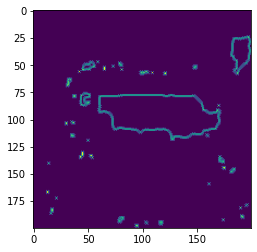

In [68]:
plt.imshow(s[200:400,800:1000])

In [69]:
ret, binary = cv2.threshold(s,1,255,cv2.THRESH_BINARY)

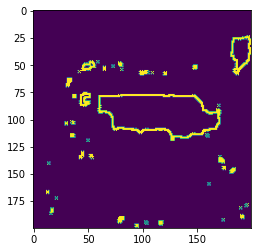

In [70]:
plt.imshow(binary[200:400,800:1000])

In [71]:
contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [73]:
len(contours)

3277

In [79]:
v = im_monnon.copy()
g_cont = []
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    if w>30 or h>30:
        pts = c.reshape((-1,1,2))
        a=cv2.polylines(v,[pts],isClosed=True,color=(0,0,255),thickness=5)
        lat = int(np.mean([j[0][0] for j in c]))
        lon = int(np.mean([j[0][1] for j in c]))
        a = cv2.circle(img=v,
           center=(lat,lon),
           radius=5,
           color=(255,0,0),
           thickness=-1)
        g_cont.append(c)

In [80]:
len(g_cont)

297

In [81]:
(df_metal['village']=='Monnon').sum()

208

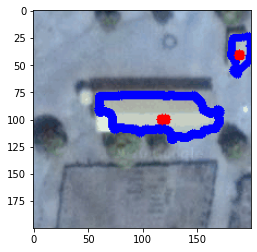

In [82]:
plt.imshow(v[200:400,800:1000])

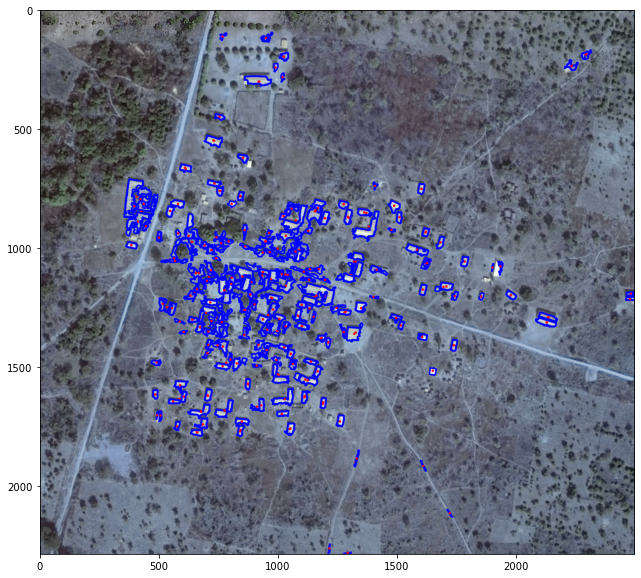

In [83]:
plt.figure(figsize=(20,10))
plt.imshow(v)

In [84]:
v.shape

(2285, 2500, 3)

## BETTER RESULTS ALG

### LOOP FOR EACH COLUMN

In [85]:
#result = np.where(195 < g_fil[:,:,0],1,0).astype(np.uint8)

In [86]:
## WITHOUT GAUSSIAN FILTER - TAKED MORE TIME
result_wo = np.where(im_monnon_mask_sum[:,:,0] == 255,1,0).astype(np.uint8)

In [87]:
kernel = np.ones((3,3),np.uint8)
result = cv2.erode(result_wo,kernel,iterations = 2)

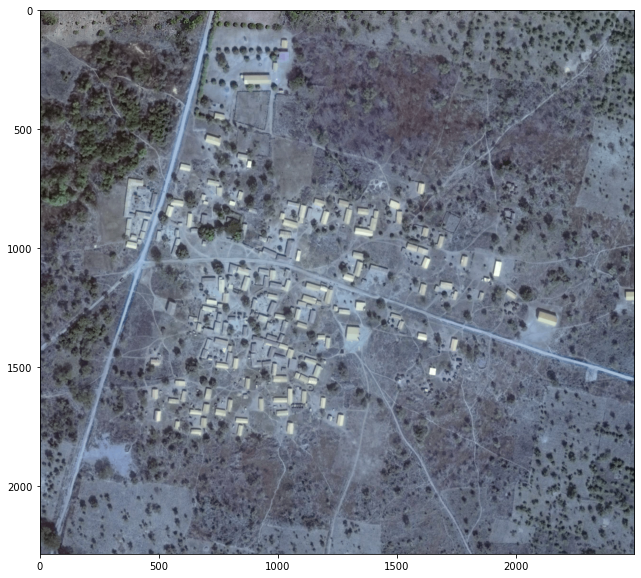

In [88]:
plt.figure(figsize=(20,10))
plt.imshow(result,'gray')
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(im_monnon)
plt.show()

In [89]:
result.shape

(2285, 2500)

In [90]:
red_groups = []
group = []
tr1 = tqdm(range(result.shape[1]))
start_time = time.time()
    
for i in tr1:
    line_group = []
    group = []
    if i==result.shape[1] or i == 0:
        continue
    for j in range(result.shape[0]-1):
        #is corner or zero
        if j == 0 or j==result.shape[0]:
            continue
        else:
            if result[j,i] == 0:
                if(len(group)==1):
                    group=[]
                continue
            elif(result[j+1,i] == 1):
                    group.append(j+1)
            elif result[j,i] == 1 and result[j-1,i] == 1:
                #check in corner
                if result[j+1,i] == 0:
                    #add to group and continue
                    group.append(j+1)
                    group.sort()
                    line_group.append(group)
                    group = []

            if result[j,i] == 1 and result[j-1,i] == 0:
                group.append(j)
    red_groups.append(line_group)
end_time = time.time()               
print("total time taken this loop: ", end_time - start_time)    

100%|██████████| 2500/2500 [00:15<00:00, 158.90it/s]

total time taken this loop:  15.733596086502075


### LOOP FOR EACH GROUP IN COLUMNS

In [91]:
all_houses = []
all_pixels = []
tlist1 = tqdm(red_groups[:-1])
start_time = time.time()
for l,line in enumerate(tlist1):
    if 0 ==len(line):
        continue
    for group in line:
        pot_house = [(l,j) for j in group]
        if pot_house[0] in all_pixels:
            continue
        else:
            gr_1 = group
            for l2,line2 in enumerate(red_groups[l+1:]):
                match = 0
                for gr in line2:
                    if 0 < len(set(gr).intersection(set(gr_1))):
                        pot_house = pot_house+[(l2+l+1,j2) for j2 in gr]
                        all_pixels = all_pixels+[(l2+l+1,j2) for j2 in gr]
                        match = 1
                        gr_1 = gr
                        break
                if match == 0:
                    all_houses.append(pot_house)
                    pot_house = []
                    break
end_time = time.time()               
print("total time taken this loop: ", end_time - start_time)

100%|██████████| 2498/2498 [02:10<00:00, 19.15it/s] 

total time taken this loop:  130.46804571151733


In [92]:
len(all_houses)

1100

In [99]:
v = im_monnon.copy()
g_cont = []
for c in all_houses:
    x = np.min([a[0] for a in c])
    y= np.min([a[1] for a in c])
    w= np.max([a[0] for a in c]) - x
    h = np.max([a[1] for a in c])-y
    if w>30 or h>30:
        cv2.rectangle(v,(x,y),(x+w,y+h),(0,0,255),2)
        a = cv2.circle(img=v,
           center=(int(x+w/2),int(y+h/2)),
           radius=5,
           color=(255,0,0),
           thickness=-1)
        g_cont.append(c)

In [100]:
len(g_cont)

278

In [101]:
(df_metal['village']=='Monnon').sum()

208

In [102]:
plt.figure(figsize=(20,10))
plt.imshow(v)